## Find Your Face Image

In [ ]:
!unzip "./Face Region Detection(Background).zip"
!unzip "./Face Region Detection.zip"

## Install Thunder-SVM

In [10]:
%pip install https://github.com/Xtra-Computing/thundersvm/releases/download/v0.3.4/thundersvm_cuda10.1-0.3.4-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 522kB 285kB/s 


# Outline
In this project, I research in region of interest proposal method just like R-CNN
##Implementation Step：
1.	Build Color Model
2.	Skin-like pixel detection using evolutionary agents
3.	Skin-like region segmentation and adjacent region graph
4.	SVM Training

Refercences：  
1. [A Novel Approach for Human Face Detection from Color Images under Complex Background, 2001](https://www.researchgate.net/publication/220600690_A_Novel_Approach_for_Human_Face_Detection_from_Color_Images_under_Complex_Background)  
2. [Face Detection Using Quantized Skin Color
Regions Merging and Wavelet Packet Analysis, IEEE, 1999](https://ieeexplore.ieee.org/document/784465)  
3. Wavelet Transform based Feature Extraction for Face Recognition, International Journal of Bioinformatics Research and Applications, 2010

## Color Model
Use RGB and HSV model to detect Skin-like pixel, threshold referenced from [1].

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


class ColorModel:
  '''Build Color Model'''
  def __init__(self, image):

    self.image = RGBHistEqu(image).astype(float)
    self.init_RG_image()
    self.init_hsv_image()

  def init_RG_image(self):
    '''
    Normalize RGB value, only care R and G channel
    I=R+G+B, r=R/I, g=G/I
    '''
    divide_mask = np.sum(self.image, axis=2) > 0
    divisor = np.sum(self.image, axis=2)
    r = np.divide(self.image[..., 0], divisor, where=divide_mask)
    np.putmask(r, ~divide_mask, 0)
    g = np.divide(self.image[..., 1], divisor, where=divide_mask)
    np.putmask(g, ~divide_mask, 0)

    self.imageRG=np.concatenate((r[..., np.newaxis], g[...,np.newaxis]),axis=2)

  def init_hsv_image(self):
    '''
    HSV Model, S and V is normalized to [0,1], H is [0, 360] degrees.
    '''
    hsv = cv2.cvtColor(self.image.astype(np.uint8), cv2.COLOR_RGB2HSV_FULL)
    h = hsv[...,0].astype(float)
    sv = hsv[...,1:].astype(float)/255
    self.imageHSV = np.concatenate((h[...,np.newaxis], sv), axis=2)

  def check_skin_pixel(self, location) -> bool:
    '''
    input:
      location: (x,y)
    output:
      True or False, is skin-like or not
    '''
    x, y = location
    if not isinstance(x, int):
      x = int(x)
    if not isinstance(y, int):
      y = int(y)

    r,g = self.imageRG[y,x,:]

    if r < 0.36 or r > 0.465 or g < 0.28 or g > 0.363:
      return False
    h, s , v = self.imageHSV[y,x,:]
    if h < 0:
      h += 360
    if not(0.<=h<=50. and 0.2<=s<=0.68 and 0.35<=v<=1.):
      return False
    return True


## Skin-like pixel detection using evolutionary agents
it referenced from [1].
1. First, Uniformly distribute an initial set of agents A, divide the image into 12*12 cells, put a agent on cell’s left-top corner.
2. Use Color Model to find skin-like pixel, if pixel where the agent locates is skin-like and has not been visited by any other agents, then reproduce son agents on 4 neighbors and remove father agent, otherwise, diffuse to one of 8 neighbors randomly, and life span add 1, if life span of agent exceeds 1, remove it.  




In [14]:
class SegmentationAgent:
  '''
  Skin-like pixel detection using evolutionary agents
  '''
  def __init__(self, image_path, resize=False):
    image = cv2.imread(image_path)
    if resize:
      h, w, _ = image.shape
      # thre is to shrink image to speed up Segmentation Agent
      thre = 800
      if h > thre:
        r = h//thre+1 if h/thre - h//thre >= 0.5 else h//thre
        w = w//r
        image = cv2.resize(image, (thre, w))
      elif w > thre:
        r = w//thre+1 if w/thre - w//thre >= 0.5 else w//thre
        h = h//r
        image = cv2.resize(image, (h, thre))

    self.image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #RGB
    self.colormodel = ColorModel(self.image)
    self.init_agent_set()

  def init_agent_set(self):
    '''
    Uniformly distribute an initial set of agents
    '''
    x_step = self.image.shape[1] // 12
    y_step = self.image.shape[0] // 12
    x = np.arange(self.image.shape[1], step=x_step) # x direction (width)
    y = np.arange(self.image.shape[0], step=y_step) # y direction (height)
    xv, yv = np.meshgrid(x,y)

    self.agent_set = np.hstack((np.hstack((xv.reshape(-1,1),yv.reshape(-1,1))), np.ones((xv.shape[0]*xv.shape[1],1)))).astype(int)


  def mark_region(self):
    '''
    main loop for mark region
    '''
    # output
    skin_region = np.zeros_like(self.image)[...,0]
    # record pixel has been visited by any other agents
    visited_by_agent = np.zeros_like(self.image)[...,0]

    while len(self.agent_set):
      index_to_keep = np.ones((len(self.agent_set)), dtype=bool)
      self.son_agents = np.zeros((0,3),dtype=int)

      for idx, item in enumerate(self.agent_set):
        x, y, life_span = item
        # x -> width direction, y -> height direction, access array -> array[y,x]
        if self.colormodel.check_skin_pixel((x,y)) and not visited_by_agent[y,x]:
          skin_region[y,x] += 1
          visited_by_agent[y,x] += 1
          # mark item can be removed
          index_to_keep[idx] = False
          # produce 4 son agents
          self.produce_4neighbors(x, y)
        else:
          # agent not to keep, remove
          index_to_keep[idx] = False
          # life span not exceed to 1
          if self.agent_set[idx,2] <= 1:
            self.diffuse_8neighbors(x,y,life_span)

      # remove some items
      self.agent_set = self.agent_set[index_to_keep, ...]
      # add son agents
      self.agent_set=np.concatenate((self.agent_set, self.son_agents), axis=0)

    return skin_region

  def produce_4neighbors(self,x, y):
    '''
    Reproduce son agents on 4 neighbors, if pixel where the agent locates is skin-like and has not been visited by any other agents
    '''
    for i in (-1,1):
      for idx, v in enumerate((x,y)):
        if idx == 0:
          # x
          new_x = x+i
          if 0 <= new_x < self.image.shape[1]:
            self.son_agents = np.concatenate((self.son_agents, np.array([[new_x,y,0]])), axis=0)
        elif idx == 1:
          # y 
          new_y = y+i
          if 0 <= new_y < self.image.shape[0]:
            self.son_agents = np.concatenate((self.son_agents, np.array([[x,new_y,0]])), axis=0)

  def diffuse_8neighbors(self, x, y, life_span):
    '''
    Diffuse to one of 8 neighbors randomly if pixel where the agent locates is not skin-like or has been visited by any other agents
    '''
    direction = np.random.randint(8)
    if direction == 0:
      new_x, new_y = x+1, y

    elif direction == 1:
      new_x, new_y = x+1, y-1

    elif direction == 2:
      new_x, new_y = x, y-1

    elif direction == 3:
      new_x, new_y = x-1, y-1

    elif direction == 4:
      new_x, new_y = x-1, y

    elif direction == 5:
      new_x, new_y = x-1, y+1

    elif direction == 6:
      new_x, new_y = x, y+1

    elif direction == 7:
      new_x, new_y = x+1, y+1

    # Check if the location is valid
    if 0 <= new_x < self.image.shape[1] and 0 <= new_y < self.image.shape[0]:
      self.son_agents = np.concatenate((self.son_agents, np.array([[new_x, new_y, life_span + 1]])), axis=0)
    else:
      # Again
      self.diffuse_8neighbors(x,y,life_span)

## Using SVM to determine whether the ROI is face or not
### Train probability SVM 
1. Positive Sample：SCUT-FBP5500 Database, has 5500 image, shape of each image is 350×350×3, image has no background.
2. Negative Sample：Fashion MNIST, has 60000 samples in its training set, 5500 samples, random pick, 28×28×1.

Data Processing：
1. Image Resize to 100×100×1
2. Use Image Histogram Equalization
3. Calculate Correlation Matrix of Image, value range is [-1, 1]

Test and training set ratio is 1:9, and test set accuracy is 96.45%, but it is poor in reality, so there may be too little data and a variety of collections.

### Download SCUT-FBP5500 Database
https://github.com/HCIILAB/SCUT-FBP5500-Database-Release

In [ ]:
!unzip Images.zip

### Prepare training set and test set

In [18]:
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split


def get_train_test():
  num = 5500
  shape = (100,100)
  x = np.zeros((0,10000))
  y = np.zeros((num))
  # negative sample
  # fashion mnist
  (mnist_x, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
  mnist_x = mnist_x[:num]
  for arr in mnist_x:
    # range [-1,1]
    arr = cv2.equalizeHist(cv2.resize(arr, shape))
    corr_coef = np.corrcoef(arr).reshape(1,-1)
    x = np.concatenate((x, corr_coef), axis=0)

  # positive sample
  for img in glob.iglob("/content/Images/*.jpg"):
    img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY), shape)
    corr_coef = np.corrcoef(cv2.equalizeHist(img)).reshape(1,-1)
    x = np.concatenate((x, corr_coef), axis=0)
  y = np.concatenate((y, np.ones((num))), axis=0)
  x = np.nan_to_num(x, posinf=1, neginf=-1)
  train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True)
  return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = get_train_test()


4423680/4422102 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


### SVM training and testing

In [20]:
from thundersvm import SVC
import time
start = time.time()
clf_prob = SVC(verbose=True, probability=True)
clf_prob.fit(train_x, train_y)
print(f"training time:{round(time.time()-start, 2)}s.")
score=clf_prob.score(test_x,test_y)
print(f"test set acc: {round(score, 4)}")
pb=clf_prob.predict_proba(test_x)
print(pb)

training time:86.23s.
test set acc: 0.9709
[[9.9998176e-01 1.8236762e-05]
 [8.4722894e-01 1.5277106e-01]
 [1.4451044e-05 9.9998558e-01]
 ...
 [2.3047569e-06 9.9999768e-01]
 [2.1388961e-02 9.7861105e-01]
 [9.9966043e-01 3.3958070e-04]]


### Save model

In [ ]:
clf_prob.save_to_file('./model_prob')

## Skin-like region segmentation and adjacent region graph
Use k-means to create segmentation on skin-like region and build adjacent region graph on segmentation, and use mean color of region to merge region, and find each bounding box of each final part. It referenced from [2].


In [21]:

from skimage.color import rgb2hsv
from skimage import data, segmentation, io, color
from skimage.future import graph
from skimage.measure import regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches

def RGBHistEqu(img):
  '''
  RGB image Histogram Equalization
  '''
  ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
  channels = cv2.split(ycrcb)
  cv2.equalizeHist(channels[0], channels[0])
  cv2.merge(channels, ycrcb)
  cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2RGB, img)
  return img


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])


class FaceSegmentation:
  '''
  Face Segmentation and detect face
  '''
  def __init__(self, image_path, resize=False):
    self.agent = SegmentationAgent(image_path, resize=resize)
    self.hsvimage = cv2.cvtColor(self.agent.image.copy(), cv2.COLOR_RGB2HSV_FULL)
  
  def get_skin_region(self):
    '''skin region with agent'''
    start = time.time()
    self.skin_region = self.agent.mark_region()
    print(f"get skin region: using {round(time.time()-start, 2)}s.")

  def show_skin_region(self):
    '''show skin region'''
    start = time.time()
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))
    plt.title("Skin Region", fontsize=14, ha="center")
    ax[0].imshow(self.skin_region, cmap="coolwarm")
    ax[0].axis("off")
    g = graph.rag_mean_color(self.agent.image, self.skin_region)
    lc = graph.show_rag(self.skin_region, g, self.agent.image, ax=ax[1])
    ax[1].axis("off")
    plt.tight_layout()
    plt.show()
    print(f"show skin region: using {round(time.time()-start, 2)}s.")

  def build_segmentation(self):
    '''
    Build segmentation based on k-means
    '''
    start = time.time()
    mask_seg = segmentation.slic(self.hsvimage, compactness=100, n_segments=400)
    mask = self.skin_region.astype(bool)
    np.putmask(mask_seg, ~mask, 0)
    self.skin_segmentation = mask_seg
    print(f"build segmentation: using {round(time.time()-start, 2)}s.")

  def show_segmentation(self):
    plt.figure()
    plt.title("Segmentation", fontsize=14, ha="center")
    out = color.label2rgb(self.skin_segmentation, self.hsvimage, kind='avg', bg_label=0, image_alpha=0.5)
    out = segmentation.mark_boundaries(out, self.skin_segmentation, (0, 0, 0))
    io.imshow(out)
    plt.axis("off")
    io.show()


  def show_bounding_box_with_seg(self):
    image_label_overlay = label2rgb(self.skin_segmentation, image=self.agent.image.copy())
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.set_title("Bounding Box", fontsize=14)
    ax.imshow(image_label_overlay)
    ax.axis("off")
    for region in regionprops(self.skin_segmentation):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    plt.show()

  def merge_seg_with_RAG(self):
    '''
    Merging based on adjacent region graph (mean color)
    '''
    start = time.time()
    rag = graph.rag_mean_color(self.hsvimage, self.skin_segmentation)
    self.skin_segmentation = graph.merge_hierarchical(self.skin_segmentation, rag, thresh=45, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)
    print(f"merge segmentation: using {round(time.time()-start, 2)}s.")

  def mark_face_region(self, clf):
    bounding_thre = 35
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.set_title("Face Detection", fontsize=14)
    ax.imshow(self.agent.image)
    ax.axis("off")
    for region in regionprops(self.skin_segmentation):
      minr, minc, maxr, maxc = region.bbox
      if maxr - minr < bounding_thre or maxc - minc < bounding_thre:
        continue
      roi = cv2.cvtColor(self.agent.image[minr:maxr, minc:maxc, :], cv2.COLOR_RGB2GRAY)
      roi = cv2.equalizeHist(cv2.resize(roi, (100,100)))
      corr_coef = np.corrcoef(roi).reshape(1,-1)
      corr_coef = np.nan_to_num(corr_coef, posinf=1, neginf=-1)
      predict = clf.predict_proba(corr_coef)
      
      rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
      ax.add_patch(rect)
      rx, ry = rect.get_xy()
      # ry = ry + rect.get_height()
      font = {'family': 'serif',
        'color':  'red',
        'weight': 'normal',
        'size': 16,
        }
      ax.text(rx,ry,str(predict[0][1]), fontdict=font)
    plt.show()





get skin region: using 36.53s.


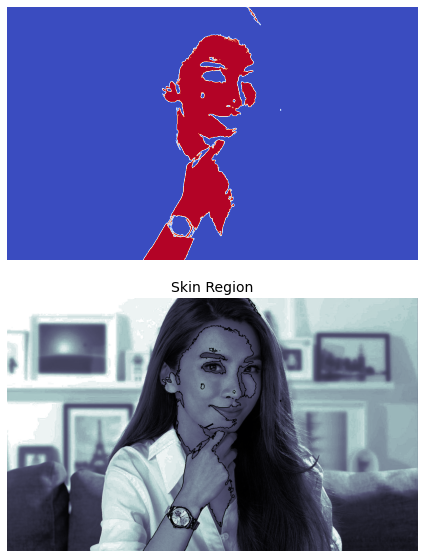

show skin region: using 7.82s.
build segmentation: using 1.1s.


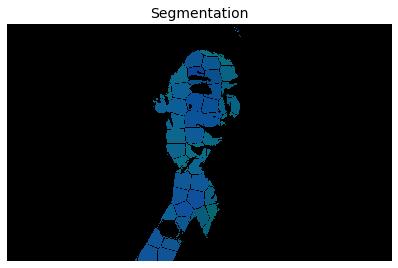

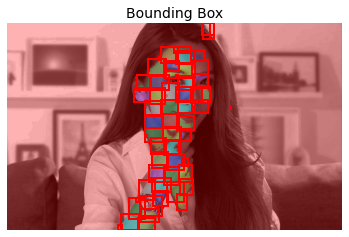

merge segmentation: using 6.97s.


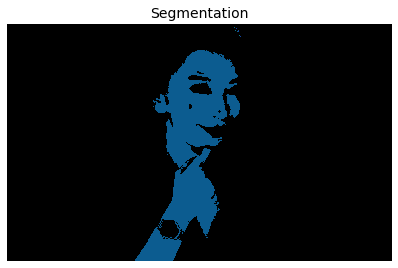

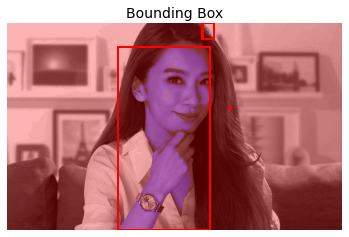

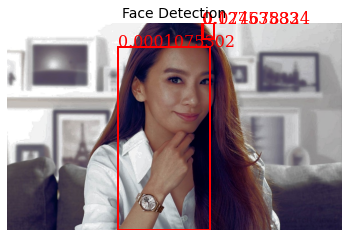

In [23]:
# img_pth = "./Face Region Detection/Face10.jpg"
img_pth ="./Face Region Detection/Face3.jpg"
F = FaceSegmentation(img_pth)
F.get_skin_region()
F.show_skin_region()
F.build_segmentation()
F.show_segmentation()
F.show_bounding_box_with_seg()
F.merge_seg_with_RAG()
F.show_segmentation()
F.show_bounding_box_with_seg()
F.mark_face_region(clf_prob)

##Demo: all image in folder

In [ ]:
from IPython.display import clear_output

import glob
image_pths = glob.glob("/content/Face Region Detection/*.jpg") 
for p in image_pths:
  clear_output(wait=True)
  print(p)
  F = FaceSegmentation(p)
  F.get_skin_region()
  try:
    F.show_skin_region()
  except:
    plt.imshow(cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB))
    print("Unable to detect faces.")
    continue
  time.sleep(2.0)
  clear_output(wait=True)
  F.build_segmentation()
  F.show_segmentation()
  time.sleep(2.0)
  clear_output(wait=True)
  F.show_bounding_box_with_seg()
  time.sleep(2.0)
  clear_output(wait=True)
  F.merge_seg_with_RAG()
  F.show_segmentation()
  time.sleep(2.0)
  clear_output(wait=True)
  F.show_bounding_box_with_seg()
  time.sleep(2.0)
  clear_output(wait=True)
  F.mark_face_region(clf_prob)
  time.sleep(2.0)
  clear_output(wait=True)
  print("Done.")



Done.
